# Imports

In [9]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load
This is where the prepared data is loaded in for use in training and testing of the model

In [10]:
# Load cleaned and preprocessed data
X_train = pd.read_csv("data/X_train.csv", index_col=0).astype(float)
y_train = pd.read_csv("data/y_train.csv", index_col=0).astype(int)
y_train = pd.Series(y_train.values.ravel())
y_train.index = X_train.index
y_train_binary = pd.read_csv("data/y_train_binary.csv", index_col=0).astype(int)
y_train_binary = pd.Series(y_train_binary.values.ravel())
y_train_binary.index = X_train.index
X_test = pd.read_csv("data/X_test.csv", index_col=0).astype(float)
y_test = pd.read_csv("data/y_test.csv", index_col=0).astype(int)
y_test = pd.Series(y_test.values.ravel())
y_test.index = X_test.index
y_test_binary = pd.read_csv("data/y_test_binary.csv", index_col=0).astype(int)
y_test_binary = pd.Series(y_test_binary.values.ravel())
y_test_binary.index = X_test.index

# Two Stage SVM RBF Model
This section is where the two stage SVM RBF model is trained and tested. First class 1 and class 2 are merged into a single class and a SVM RBF model is trained to predict class 0 against the combined class 1 and 2. A second model is then trained to predict class 1 against class 2. The output of these two models is then combined to create a prediction of all classes

In [11]:
#Model parameters
desired_c = 1
desired_gamma = 0.01

# Stage 1: SVM RBF - 0 vs (1+2)
svm_stage1 = SVC(kernel='rbf', gamma=desired_gamma, C=desired_c, probability=True, class_weight='balanced')
svm_stage1.fit(X_train, y_train_binary)

y_pred_binary = svm_stage1.predict(X_test)
y_prob_binary = svm_stage1.predict_proba(X_test)

print("\nStage 1 SVM RBF Classification Report (0 vs 1+2):")
print(classification_report(y_test_binary, y_pred_binary))

# Stage 2: SVM RBF - 1 vs 2
# Get original test labels with 0/1/2
y_test_full = y_test.loc[y_test_binary.index]

# Find samples predicted as diabetic
indices_pred_diabetes = np.where(y_pred_binary == 1)[0]
X_test_diabetes = X_test.iloc[indices_pred_diabetes]
y_test_diabetes = y_test_full.iloc[indices_pred_diabetes]

# Keep only class 1 and 2
# Pull records where y_test_diabetes is class 1 or class 2, along with their indexes
test_diabetes = y_test_diabetes.loc[(y_test_diabetes == 1) | (y_test_diabetes == 2)].index
X_test_diabetes = X_test_diabetes.loc[test_diabetes]
y_test_diabetes = y_test_diabetes.loc[test_diabetes]

# Prepare second-stage training data
# Get the indexes where y_train_binary == 1
diabetes_indexes = y_train_binary.loc[y_train_binary == 1].index

# Use these indexes to select records from X_train_diabetes and y_train_diabetes
X_train_diabetes = X_train.loc[diabetes_indexes]
y_train_diabetes = y_train.loc[diabetes_indexes]

# Train second SVM
svm_stage2 = SVC(kernel='rbf', gamma=desired_gamma, C=desired_c, probability=True, class_weight='balanced')
svm_stage2.fit(X_train_diabetes, y_train_diabetes)

y_pred_second_stage = svm_stage2.predict(X_test_diabetes)
y_prob_second_stage = svm_stage2.predict_proba(X_test_diabetes)

print("\n\nStage 2 SVM RBF Classification Report (1 vs 2):")
print(classification_report(y_test_diabetes, y_pred_second_stage))

# Reconstruct final prediction array
y_pred_final = y_pred_binary.copy()
pred_diabetes_indices = np.where(y_pred_binary == 1)[0]

# Reindex and assign
y_test_full_diabetes = y_test_full.iloc[pred_diabetes_indices]
valid_indices = pred_diabetes_indices[(y_test_full_diabetes == 1) | (y_test_full_diabetes == 2)]

for i, idx in enumerate(valid_indices):
    y_pred_final[idx] = y_pred_second_stage[i]

print("\nFinal SVM RBF Classification Report:")
print(classification_report(y_test_full, y_pred_final))


Stage 1 SVM RBF Classification Report (0 vs 1+2):
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     38012
           1       0.33      0.82      0.47      7945

    accuracy                           0.68     45957
   macro avg       0.64      0.73      0.62     45957
weighted avg       0.84      0.68      0.72     45957



Stage 2 SVM RBF Classification Report (1 vs 2):
              precision    recall  f1-score   support

           1       0.15      0.34      0.21       664
           2       0.91      0.77      0.84      5824

    accuracy                           0.73      6488
   macro avg       0.53      0.56      0.52      6488
weighted avg       0.83      0.73      0.77      6488


Final SVM RBF Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77     38012
           1       0.02      0.25      0.03       926
           2       0.91      0.64      0.75 

# Export
This section is where the final predictions of the two stage SVM RBF model are exported for use by the ensemble

In [12]:
# Save final predictions
# --------------------------------------------
import os
os.makedirs("results", exist_ok=True)
np.save("results/y_pred_svm.npy", y_pred_final)

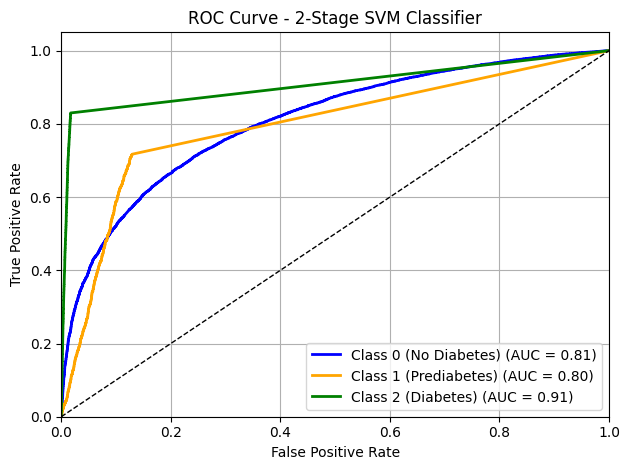

In [13]:
# First stage probabilities for class 1+2
prob_first_stage = y_prob_binary[:, 1]  # P(class 1+2)

# Use second stage probabilities for diabetic samples only
# Initialize full probability matrix
y_score = np.zeros((len(X_test), 3))  # columns: [class 0, class 1, class 2]

# Class 0 = 1 - P(class 1+2)
y_score[:, 0] = 1 - prob_first_stage

# Fill in class 1 and 2 scores for predicted-diabetes cases
for i, global_idx in enumerate(test_diabetes):
    prob_1 = y_prob_second_stage[i, 0]
    prob_2 = y_prob_second_stage[i, 1]
    diabetes_prob = prob_first_stage[X_test.index.get_loc(global_idx)]
    
    y_score[X_test.index.get_loc(global_idx), 1] = diabetes_prob * prob_1
    y_score[X_test.index.get_loc(global_idx), 2] = diabetes_prob * prob_2

# Binarize true labels
y_test_bin = label_binarize(y_test_full, classes=[0, 1, 2])

# Plot all ROC classes
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - 2-Stage SVM Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

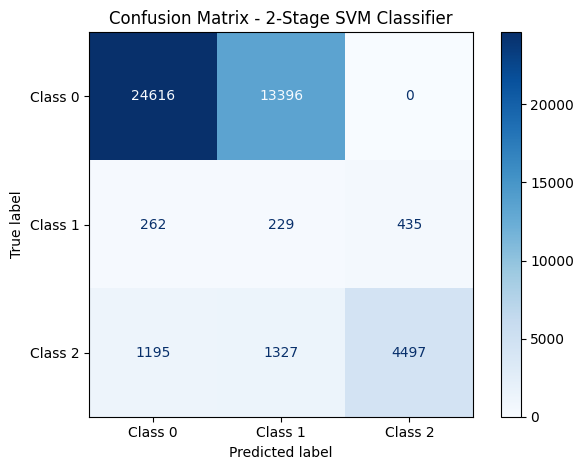

In [14]:
cm = confusion_matrix(y_test_full, y_pred_final, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - 2-Stage SVM Classifier")
plt.grid(False)
plt.tight_layout()
plt.show()